<a href="https://colab.research.google.com/github/AissatouPaye/AnomalyDetection.jl/blob/master/f_AnoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# paper

https://arxiv.org/abs/1802.06222



- matplotlib==3.0.3
- opencv-python==3.4.5.20
- numpy==1.16.5
- Keras==2.2.5
- scikit-image==0.15.0
- scikit-learn==0.21.3
- scipy==1.3.1
- tensorflow==1.14.0
- tqdm==4.28.1
- h5py==2.8.0

In [0]:
import matplotlib

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import math

from keras.utils. generic_utils import Progbar
from keras.utils.vis_utils import plot_model

from typing import Tuple
from keras.models import load_model
from sklearn.manifold import TSNE
from keras.layers import concatenate

# Google Colab
from google.colab import drive

from sklearn.manifold import TSNE
import copy
from enum import Enum

from keras.callbacks import TensorBoard
import io
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from math import floor
from skimage.transform import resize
from scipy.linalg import sqrtm

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set path to save model



- Google Colab Specified when operating with：'/content/drive/My Drive/'
Up to a common path, after that it depends on Drive


Reduce hard coding by enumerating variables that are used many times. Completion is also done when using the IDE

In [0]:
class DataParm(Enum):
    # AnnoGAN Path to save  models, images, and Tensorboard logs
    common_path = '/ content / drive / My Drive /GAN/'
    # EfficentAnnoGAN: Path to store the model, images, and Tensorboard logs
    common_path_efficient = '/ content / drive / My Drive /GAN/f-AnoGAN/'
    image_size_127_5 = 127.5
    batch_size_64 = 64

# Generator Model

Generator : Functions that create models

Enum : Set the parameter class that has, reduce hard coding, and understand the meaning of each parameter

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 6272)              68992     
_________________________________________________________________
batch_normalization_771 (Bat (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_793 (Conv2D)          (None, 14, 14, 64)        369

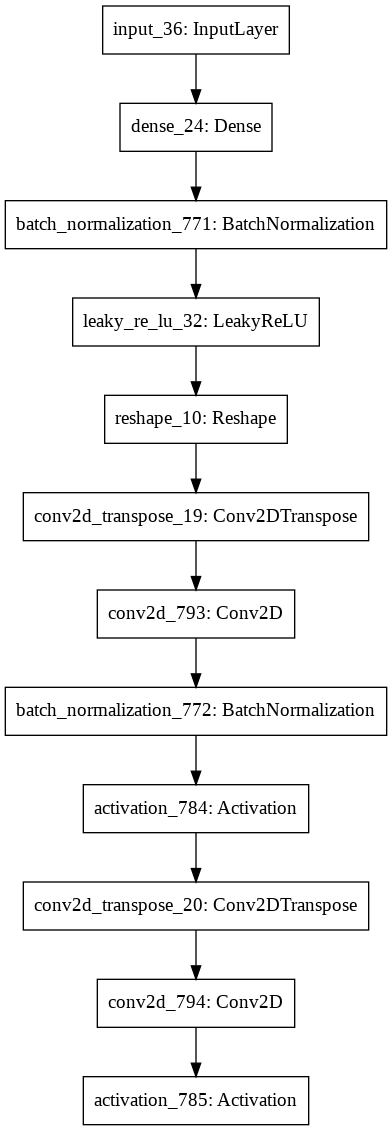

In [56]:
class GeneratorParam(Enum):
    units_128_7_7 = 128*7*7
    leaky_relu_param_0_2 = 0.2
    reshape_size_7_7_128 = (7, 7, 128)
    
    conv2d_transpose_filter_64 = 64
    conv2d_transpose_kernel_2_2 = (2, 2)
    conv2d_transpose_stride_2_2 = (2, 2)
    
    conv2d_filter_64 = 64
    conv2d_kernel_3_3 = (3, 3)
    conv2d_padding_same = 'same'
    
    activation_relu = 'relu'
    
    conv2d_out_filter_1 = 1
    conv2d_out_kernel_5_5 = (5, 5)
    out_activation_tanh = 'tanh'
    

def generator_model(in_shape: tuple=(10,)) -> Model:
    """
    生成モデルの作成
    
    Parameters
    ----------
    in_shape : tuple
        Dimension of noise space
    
    Returns
    -------
    model: Model
        作成した生成モデル
    """
    inputs = Input(in_shape)
    fc1 = Dense(input_dim=in_shape[0], units=GeneratorParam.units_128_7_7.value)(inputs)
    # 学習を安定させるための工夫
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(GeneratorParam.leaky_relu_param_0_2.value)(fc1)
    # 7x7の画像サイズに変換するための処理
    fc2 = Reshape(GeneratorParam.reshape_size_7_7_128.value, input_shape=(GeneratorParam.units_128_7_7.value,))(fc1)
    # 14x14の画像サイズに変換するための処理
    up1 = Conv2DTranspose(GeneratorParam.conv2d_transpose_filter_64.value, 
                          GeneratorParam.conv2d_transpose_kernel_2_2.value, 
                          strides=GeneratorParam.conv2d_transpose_stride_2_2.value, 
                          padding=GeneratorParam.conv2d_padding_same.value)(fc2)
    conv1 = Conv2D(GeneratorParam.conv2d_filter_64.value, 
                   GeneratorParam.conv2d_kernel_3_3.value, 
                   padding=GeneratorParam.conv2d_padding_same.value)(up1)
    # 学習を安定させるための工夫
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(GeneratorParam.activation_relu.value)(conv1)
    # 28x28の画像サイズに変換するための処理
    up2 = Conv2DTranspose(GeneratorParam.conv2d_transpose_filter_64.value, 
                          GeneratorParam.conv2d_transpose_kernel_2_2.value, 
                          strides=GeneratorParam.conv2d_transpose_stride_2_2.value, 
                          padding=GeneratorParam.conv2d_padding_same.value)(conv1)
    # チャネルを1チャネルにして白黒画像に変換
    conv2 = Conv2D(GeneratorParam.conv2d_out_filter_1.value, 
                   GeneratorParam.conv2d_out_kernel_5_5.value, 
                   padding=GeneratorParam.conv2d_padding_same.value)(up2)
    outputs = Activation(GeneratorParam.out_activation_tanh.value)(conv2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
  
g_model = generator_model()
g_model.summary()
plot_model(g_model, to_file='g_model.png')

# Discriminator

In [0]:
class DiscriminatorParam(Enum):
    conv2d_filter_64 = 64
    conv2d_kernel_5_5 = (5, 5)
    conv2d_stride_2_2 = (2, 2)
    conv2d_padding_same = 'same'
    
    leaky_reLU_param_0_2 = 0.2
    
    conv2d_second_filter_128 = 128
    conv2d_second_kernel_5_5 = (5, 5)
    conv2d_second_stride_2_2 = (2, 2)
    conv2d_second_padding_same = 'same'
    
    dense_1 = 1
    
    out_activation_sigmoid = 'sigmoid'

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_795 (Conv2D)          (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_796 (Conv2D)          (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 627

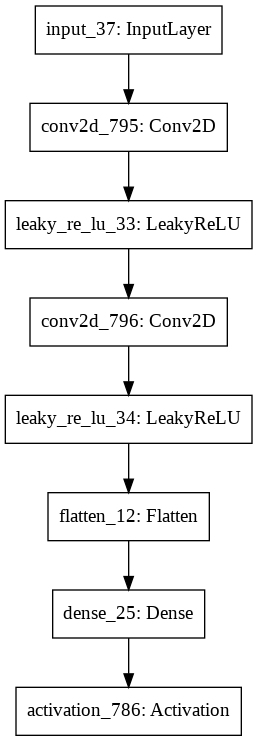

In [58]:
def discriminator_model(image_shape: tuple=(28, 28, 1)) -> Model:
    """
    生成モデルの作成
    
    Parameters
    ----------
    image_shape : tuple
        画像の次元
    
    Returns
    -------
    model: Model
        作成した識別モデル
    """
    inputs = Input(image_shape)
    # 画像を14x14x64の特徴マップに変更
    conv1 = Conv2D(DiscriminatorParam.conv2d_filter_64.value, 
                   DiscriminatorParam.conv2d_kernel_5_5.value, 
                   strides=DiscriminatorParam.conv2d_stride_2_2.value, 
                   padding=DiscriminatorParam.conv2d_padding_same.value)(inputs)
    conv1 = LeakyReLU(DiscriminatorParam.leaky_reLU_param_0_2.value)(conv1)
    # 画像を7x7x18の特徴マップに変更
    conv2 = Conv2D(DiscriminatorParam.conv2d_second_filter_128.value, 
                   DiscriminatorParam.conv2d_second_kernel_5_5.value,
                   strides=DiscriminatorParam.conv2d_second_stride_2_2.value, 
                   padding=DiscriminatorParam.conv2d_second_padding_same.value)(conv1)
    conv2 = LeakyReLU(DiscriminatorParam.leaky_reLU_param_0_2.value)(conv2)
    fc1 = Flatten()(conv2)
    # 偽物と本物の分類のため、1クラス出力
    fc1 = Dense(DiscriminatorParam.dense_1.value)(fc1)
    outputs = Activation(DiscriminatorParam.out_activation_sigmoid.value)(fc1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
  
d_model = discriminator_model()
d_model.summary()
plot_model(d_model, to_file='d_model.png')

# Generator contatining Discriminator

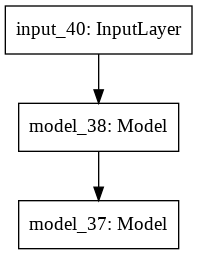

In [59]:
def generator_containint_discriminator(g: Model, d: Model, in_shape: tuple=(10,)) -> Model:
    """
    DiscriminatorとGeneratorモデルの合成
    
    Parameters
    ----------
    g : Model
        生成モデル
    d : Model
        識別モデル
    
    Returns
    -------
    gan : Model
        識別モデルの学習はせずに生成モデルのみ学習するための混合モデル
    """
    # Generatorのみ学習するための設定
    d.trainable = False
    # ノイズを入力するための設定
    ganInput = Input(shape=in_shape)
    # ノイズをGeneratorに入力
    x = g(ganInput)
    # 生成画像をDiscriminatorに入力
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    return gan

d_model = discriminator_model()
g_model = generator_model()
g_d_model = generator_containint_discriminator(g_model, d_model)
plot_model(g_d_model, to_file='g_d_model.png')

# Combine Images

In [0]:
def combine_images(generated_images: np.ndarray) -> np.ndarray:
    """
    学習の進捗を確認するため生成画像を合成
    
    Parameters
    ----------
    generated_images : np.ndarray
        バッチサイズ分生成した画像

    Returns
    -------
    image: np.ndarray
        生成画像を合成して一つの大きな画像に修正
    """
    # 生成画像の数
    num = generated_images.shape[0]
    # 生成画像の幅
    width = int(math.sqrt(num))
    # 生成画像の高さ
    heigh = int(math.ceil(float(num) / width))
    # 生成画像の高さ、幅、チャネル数を取得
    shape = generated_images.shape[1:4]
    # 高さ、幅をスケーリング
    image = np.zeros((heigh * shape[0], width*shape[1], shape[2]), dtype=generated_images.dtype)
    # 生成した画像データそれぞれを1つの大きな画像データに埋め込むための処理
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]: (i+1) * shape[0], j * shape[1]:(j + 1) * shape[1], :] = img[:, :, :]
    return image

# Load Model

In [0]:
def load_models(common_path: str=DataParm.common_path.value) -> Tuple[Model, Model]:
    """
    学習した生成モデルと識別モデルを読み込む
    
    Parameters
    ----------
    common_path : str
        モデルを読み込むパスを指定

    Returns
    -------
    g: Model
        生成モデル
    d: Model
        識別モデル
    """
    d = load_model(common_path + '/weights/discriminator.h5')
    g = load_model(common_path + '/weights/generator.h5')
    return g, d

## TensorBoardの設定

In [0]:
def write_log(callback, names, logs, epoch):
    """
    Tensorboardにロスを保存する
    
    Parameters
    ----------
    callback: TensorBoard
        Callback関数のTensorboardを設定
    names: str
        保存するログの名前を設定
    logs: 
        保存する値を設定
    epoch: int
        epoch数を設定

    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, epoch)
        callback.writer.flush()
        

log_path = DataParm.common_path.value + '/logs'
callback = TensorBoard(log_path)

## Inception Scoreを計算

画像の質と多様性を計算

In [0]:
def scale_images(images: np.asarray, new_shape: tuple) -> np.asarray:
    """"
    画像のサイズを変更(Inception Modelで推論可能なサイズに変更する)
    Parameters
    ----------
    images: np.asarray
        バッチサイズ分の画像データ
    new_shape: tuple
        変更したい画像のサイズ
    Returns
    -------
        サイズ変更した画像のlist
    """
    images_list = list()
    for image in images:
        # 画像のサイズを変更
        new_image = resize(image, new_shape, 0)
        # listでサイズが変更された画像を保持
        images_list.append(new_image)
    return np.array(images_list)


def calculate_inception_score(images: np.asarray, model: Model=InceptionV3(), n_split: int=10, eps: float=1E-16) -> Tuple[np.asarray, np.asarray]:
    """
    Inception Scoreの平均と標準偏差を計算
    Parameters
    ----------
    images: np.asarray
        複数の画像データ
    model: Model
        推論するモデル
    n_split: int
        複数の画像データをグループごとに分割するためのグループ数
    eps: float
        対数計算をする場合に0にならないように値を足す
    Returns
        is_avg: float
            Inception Score 平均
        is_std: float
            Inception Score 標準偏差
    -------
    """
    scores = list()
    # グループ数を計算
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # 画像をグループごとに取得する
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # float32に変換
        subset = subset.astype("float32")
        # Inception Modelで推論可能なサイズに変更
        subset = scale_images(subset, (299, 299, 3))
        # [-1,1]に前処理
        subset = preprocess_input(subset)
        # p(y|x)を推論
        p_yx = model.predict(subset)
        # クラスごとのp(y)を推論
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        # 対数確率のKL divergence計算
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        # クラスごとのKL divergenceの総和
        sum_kl_d = kl_d.sum(axis=1)
        # KL divergenceの平均
        avg_kl_d = np.mean(sum_kl_d)
        # KL divergenceを対数領域から戻す
        is_score = np.exp(avg_kl_d)
        # listで保持する
        scores.append(is_score)
    # 平均と標準偏差を計算
    is_avg, is_std = np.mean(scores), np.std(scores)
    return is_avg, is_std

## FIDの計算

実画像との距離を計算

In [0]:
def calculate_fid(real_images: np.asarray, generate_images: np.asarray, model: Model=InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))) -> float:
    """
    FIDを計算する
    Parameters
    ----------
    real_images: np.asarray
        複数の実画像を設定
    generate_images: np.asarray
        複数の生成画像を設定
    model: Model
        特徴量抽出モデルを設定
    Returns
        fid: float
        FIDを計算
    -------
    """
    # 推論可能なfloat32に変更
    real_images = real_images.astype("float32")
    generate_images = generate_images.astype("float32")
    # 画像のサイズを変更
    real_images = scale_images(real_images, (299, 299, 3))
    generate_images = scale_images(generate_images, (299, 299, 3))
    # 画像の前処理
    real_images = preprocess_input(real_images)
    generate_images = preprocess_input(generate_images)
    # 特徴量抽出
    act1 = model.predict(real_images)
    act2 = model.predict(generate_images)
    # 平均ベクトルと共分散行列を計算
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # 実画像と生成画像の平均ベクトルの差の2乗の総和を計算
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # 共分散行列の積のルートを計算
    covmean = sqrtm(sigma1.dot(sigma2))
    # 複素数の場合は実部のみ取得
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # FIDを計算
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Train


In [0]:
class TrainParam(Enum):
    discriminator_lr_0_0004 = 0.0004
    generator_lr_0_0002 = 0.0002
    
    discriminator_loss_mse = "mse"
    generator_loss_mse = "mse"

In [0]:
def train(batch_size: int, X_train: np.ndarray, epoch: int=10, common_path: str=DataParm.common_path.value) -> Tuple[Model, Model]:
    """
    識別モデルと生成モデルを学習する
    
    Parameters
    ----------
    batch_size: int
        バッチサイズ
    X_train: np.ndarray
        学習用画像データ
    epoch: int
        学習のエポック数を指定
    common_path : str
        モデル、生成画像を保存するパスを指定

    Returns
    -------
    d: Model
        識別モデル
    g: Model
        生成モデル

    """
    d = discriminator_model()
    g = generator_model()
    # Generatorのモデルを学習するための混合モデル
    d_on_g = generator_containint_discriminator(g, d)
    # Optimizerの設定
    d_optim = RMSprop(lr=TrainParam.discriminator_lr_0_0004.value)
    g_optim = RMSprop(lr=TrainParam.generator_lr_0_0002.value)
    g.compile(loss=TrainParam.generator_loss_mse.value, optimizer=g_optim)
    d_on_g.compile(loss=TrainParam.discriminator_loss_mse.value, optimizer=g_optim)
    d.trainable= True
    d.compile(loss=TrainParam.discriminator_loss_mse.value, optimizer=d_optim)
    # Inception score モデル
    is_model = InceptionV3(include_top=True, input_shape=(299, 299, 3))
    # 特徴量抽出モデル
    fid_model = InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))
    
    for e in range(epoch):
        print('Eposh is ', e)
        # データサイズ / バッチサイズ = データサイズで何回バッチ処理が行えるか計算
        n_iter = int(X_train.shape[0] / batch_size)
        # 学習の進捗を分かりやすくするための処理
        progress_bar = Progbar(target=n_iter)
        
        
        for index in range(n_iter):
            # バッチサイズ分、10次元のノイズを取得
            noise = np.random.uniform(0, 1, size=(batch_size, 10))
            # 画像をバッチサイズ分取得
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # ノイズから画像を生成
            generated_images = g.predict(noise, verbose=0)
            
            # 生成画像を保存して後で確認できるようにする
            if index % 20 == 0:
                # バッチサイズ分画像ができるので1枚の画像に変換
                image = combine_images(generated_images)
                # -1 to 1スケールなので255スケールに変換
                image = image * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value

                if not os.path.exists(common_path + '/result/'):
                    os.makedirs(common_path + '/result/')
                cv2.imwrite(common_path + '/result/' + str(e) + '_' + str(index) + '.png', image)

            # 実画像と生成画像を1つに合わせる
            x = np.concatenate((image_batch, generated_images))
            # リアル画像のラベル、生成画像のラベル
            y = np.array([1] * batch_size + [0] * batch_size)
            
            # Discriminatorの学習
            d_loss = d.train_on_batch(x, y)

            # Discriminatorの学習はしない
            d.trainable = False

            # Generatorの学習
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * batch_size))
            d.trainable = True
            
            # プログレスバーを表示して学習の進捗状況を把握する
            progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])
        
        # Tensorboardの書き込み
        callback.set_model(d)
        write_log(callback, ['d_loss'], [d_loss], e)
            
        callback.set_model(d_on_g)
        # Inception Scoreの計算
        is_avg, is_std = calculate_inception_score(generated_images, is_model)
        # FIDの計算
        fid = calculate_fid(image_batch, generated_images, fid_model)

        write_log(callback, ['g_loss', 'inception_score_average', 'inception_score_std', 'fid'], [g_loss, is_avg, is_std, fid], e)
        
        print('')
        # 学習した生成モデル、識別モデルを保存する
        if not os.path.exists(common_path + '/weights/'):
            os.makedirs(common_path + '/weights/')
        g.save(common_path + '/weights/generator.h5')
        d.save(common_path + '/weights/discriminator.h5')
    return d, g

# Generatorを用いてデータ生成

In [0]:
def generate(batch_size: int, common_path: str=DataParm.common_path.value, noize_size: int=10) -> np.ndarray:
    """
    生成モデルを使用して画像を生成する
    
    Parameters
    ----------
    batch_size: int
        バッチサイズ
    common_path : str
        モデルを読み込むパスを指定
    noize_size: int
        ノイズの次元

    Returns
    -------
    generated_images: np.ndarray
        生成画像をnumpy形式で渡す

    """
    g = load_model(common_path + '/weights/generator.h5')
    noise = np.random.uniform(0, 1, (batch_size, noize_size))
    generated_images = g.predict(noise)
    return generated_images

# Residual Lossを設定

In [0]:
def sum_of_residual(y_true: np.array, y_pred: np.array):
    """
    生成モデル、識別モデルの異常度を計算する関数
    
    Parameters
    ----------
    y_true: np.array
        ターゲットとなるデータ
    y_pred: np.array
        モデルの予測値

    Returns
    -------
        Residual Lossを計算する

    """
    return K.sum(K.abs(y_true - y_pred))

# Feature Extractor

In [0]:
class FeatureExtractorParam(Enum):
    loss_binary_crossentropy = "binary_crossentropy"
    optimizer_rmsprop = "rmsprop"
    feature_extract_layer_first_conv = -7

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_989 (Conv2D)          (None, 14, 14, 64)        1664      
Total params: 1,664
Trainable params: 1,664
Non-trainable params: 0
_________________________________________________________________


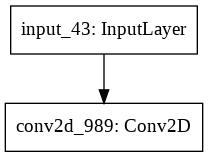

In [70]:
def feature_extractor(d: Model=None, common_path: str=DataParm.common_path.value) -> Model:
    """
    識別モデルから特徴量抽出モデルを取得する
    
    Parameters
    ----------
    d: Model
        識別モデル
    common_path: str
        モデルを読み込むパスの設定

    Returns
    -------
    intermidiate_model: Model
        特徴量抽出モデル

    """
    if d is None:
        d = load_model(common_path + '/weights/discriminator.h5')
        d.summary()
    # Discriminatorの特徴量抽出器を設定
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[FeatureExtractorParam.feature_extract_layer_first_conv.value].output)
    intermidiate_model.compile(loss=FeatureExtractorParam.loss_binary_crossentropy.value, optimizer=FeatureExtractorParam.optimizer_rmsprop.value)
    return intermidiate_model
  
d_model = discriminator_model()
f_model = feature_extractor(d_model)
f_model.summary()
plot_model(f_model, to_file='f_model.png')

# Anomaly Detector

In [0]:
class AnomalyDetectorParam(Enum):
    activation_sigmoid = "sigmoid"
    optimizer_rmsprop = 'rmsprop'

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_982 (Activation)  (None, 10)                0         
_________________________________________________________________
model_45 (Model)             (None, 28, 28, 1)         182145    
_________________________________________________________________
model_44 (Model)             (None, 14, 14, 64)        1664      
Total params: 183,919
Trainable params: 1,774
Non-trainable params: 182,145
_________________________________________________________________


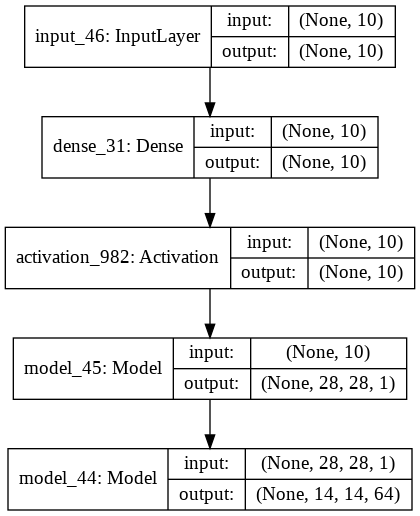

In [72]:
def anomaly_detector(g: Model, d: Model, in_shape: tuple=(10,), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    ノイズを生成する層を調整して異常スコアと画像を生成するモデルを作成
    
    Parameters
    ----------
    g: Model
        生成モデル
    d: Model
        識別モデル
    in_shape: tuple
        ノイズの入力サイズ
    loss_weights: list
        ロスの重要性を設定

    Returns
    -------
    model: Model
        異常スコアと画像を生成するモデル

    """
    # 特徴量抽出モデルをDiscriminatorから作成
    intermidiate_model = feature_extractor(d)
    # 特徴量抽出モデルは学習しない
    feature_extractor.trainable = False
    # Generatorを作成
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Generatorは学習しない
    g.trainable = False
    # Noizeを学習するためのレイヤー
    aInput = Input(shape=in_shape)
    gInput = Dense(in_shape[0], trainable=True)(aInput)
    gInput = Activation(AnomalyDetectorParam.activation_sigmoid.value)(gInput)
    
    # ノイズを入力に画像を生成
    G_out = g(gInput)
    # 画像から特徴量抽出
    D_out = intermidiate_model(G_out)
    # 画像と特徴量を出力とするモデルを作成
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorParam.optimizer_rmsprop.value)
    
    # BatchNormを固定して学習しないようにする
    K.set_learning_phase(0)
    
    return model
  
g_model = generator_model()
d_model = discriminator_model()
a_model = anomaly_detector(g_model, d_model)
a_model.summary()
plot_model(a_model, to_file="anomaly_plot.png", show_shapes=True, show_layer_names=True)

# 異常スコアを計算する関数

In [0]:
def compute_anomaly_score(model: Model, x: np.array, iterations: int=500, d: Model=None, noize_shape: tuple=(1, 10)) -> Tuple[np.asarray, np.asarray,]:
    """
    異常スコアを計算する関数
    
    Parameters
    ----------
    g: Model
        異常スコアを計算するモデル
    x: np.array
        検証用画像
    iterations: int
        イテレーションを設定
    d: Model
        識別モデル

    Returns
    -------
    loss: np.asarray
        異常スコア
    similar_data: np.asarray
        ノイズを調整したモデルにノイズを入力して画像を生成
    """
    # ノイズを作成
    z = np.random.uniform(0, 1, size=noize_shape)
    # 特徴量抽出モデルを作成
    intermidiate_model = feature_extractor(d)
    # 実画像の特徴量抽出
    d_x = intermidiate_model.predict(x)
    # ノイズを入力として、実画像、実画像の特徴量をターゲットとしたノイズの学習を行う
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    # ノイズから画像を作成
    similar_data, _ = model.predict(z)
    # 異常スコアを導出
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

- 学習データとテストデータを取得

- データは-1から1でスケーリングする

- ラベル1の学習データをGANの学習用に使用。

- 検証にはラベル1のテストデータとそれ以外のラベルのテストデータを使用

In [0]:
# mnistの画像とラベルを取得
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 画像のスケールを-1 to 1に変換
X_train = (X_train.astype(np.float32) - DataParm.image_size_127_5.value) / DataParm.image_size_127_5.value
X_test = (X_test.astype(np.float32) - DataParm.image_size_127_5.value) / DataParm.image_size_127_5.value

# バッチサイズ、幅、高さ、チャネルに変換
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

# オリジナル画像として保持
X_test_original = X_test.copy()

# ラベルの1の画像のみを対象に学習
X_train = X_train[y_train==1]
X_test = X_test[y_test==1]

ラベル1のデータを学習する

In [75]:
%%time
batch_size = DataParm.batch_size_64.value
Model_d, Model_g = train(batch_size, X_train)

Eposh is  0
104/105 [============================>.] - ETA: 0s - g: 0.2930 - d: 0.2366
Eposh is  1
104/105 [============================>.] - ETA: 0s - g: 0.3088 - d: 0.2438
Eposh is  2
104/105 [============================>.] - ETA: 0s - g: 0.2797 - d: 0.2462
Eposh is  3
104/105 [============================>.] - ETA: 0s - g: 0.2797 - d: 0.2445
Eposh is  4
104/105 [============================>.] - ETA: 0s - g: 0.2798 - d: 0.2435
Eposh is  5
104/105 [============================>.] - ETA: 0s - g: 0.2830 - d: 0.2405
Eposh is  6
104/105 [============================>.] - ETA: 0s - g: 0.2894 - d: 0.2362
Eposh is  7
104/105 [============================>.] - ETA: 0s - g: 0.3038 - d: 0.2290
Eposh is  8
104/105 [============================>.] - ETA: 0s - g: 0.3221 - d: 0.2207
Eposh is  9
104/105 [============================>.] - ETA: 0s - g: 0.3421 - d: 0.2132
CPU times: user 11min 51s, sys: 1min 33s, total: 13min 25s
Wall time: 10min 17s


Tensorboard : to check the log of the model

In [76]:
%load_ext tensorboard 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [77]:
%tensorboard --logdir /content/drive/My Drive/GAN/f-AnoGAN/logs/

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL] [--db URI]
                   [--db_import] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
tensorboard: error: unrecognized arguments: Drive/GAN/f-AnoGAN/logs/

異常スコアを計算する関数

In [0]:
def anomaly_detection(test_img: np.asarray, g: Model, d: Model, iteration: int=200) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
    異常スコアを計算する関数
    
    Parameters
    ----------
    test_img: np.asarray
        検証用の画像
    g: Model
        異常スコアを計算するモデル
    d: Model
        識別モデル
    iterations: int
        イテレーションを設定

    Returns
    -------
    ano_score: np.asarray
        異常スコア
    original_x: np.asarray
       0-255の画素領域に調整した検証用画像
    similiar_x: np.asarray
       異常スコアを計算するモデルから生成された画像
    show:
       検証用画像と生成された画像の差分
    """
    # 異常スコアを計算するモデル
    model = anomaly_detector(g=g, d=d)
    # 画像のシェイプを取得
    test_img_shape = test_img.shape
    # テスト画像から異常スコアと類似画像を推定
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), iterations=iteration, d=d)
    
    # 実画像と類似画像の差分を導出
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4
    
    # uint8化して255倍する。0-255の画素領域にする
    np_residual = (255 * np_residual).astype(np.uint8)
    # オリジナルが画像と類似画像も同様に0-255画素領域にする
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    
    # GRAYカラー画像に変換
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    
    return ano_score, original_x, similiar_x, show

7の画像を異常画像として用意

In [0]:
img_index = 14
label_index = 7
test_image = X_test_original[y_test==label_index][img_index]

学習済みの生成モデルと識別モデルを取得

In [0]:
g, d  = load_models(common_path=DataParm.common_path.value)

異常スコア、検証用画像、予測画像、差分画像を導出

In [0]:
%%time
start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection(test_image, g=g, d=d, iteration=200)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 175.33 6429.97ms
CPU times: user 1min 3s, sys: 1.09 s, total: 1min 4s
Wall time: 1min 4s


7の画像は学習されていないので生成される1と画像との差分が表示される

anomaly score :  175.3253173828125


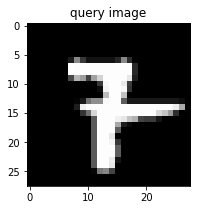

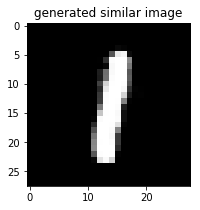

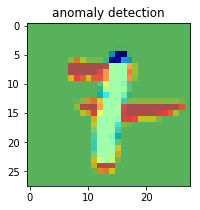

In [0]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

# ノイズ画像と1の画像とそれ以外の画像の特徴量空間を観測してみる

random noise image


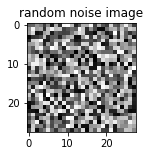

In [0]:
# 28x28x1の画像を100枚作成
random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)

可視化をして画像を確認するために特徴量を抽出します。

In [0]:
model = feature_extractor()
# ランダムな画像から特徴量抽出
feature_map_of_random = model.predict(random_image, verbose=1)
# ラベルが1でない画像の特徴量を抽出
feature_map_mnist = model.predict(X_test_original[y_test != 1][:300], verbose=1)
# ラベルが1の画像の特徴量を抽出
feature_map_mnist_1 = model.predict(X_test[:100], verbose=1)

Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1570 (Conv2D)         (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1571 (Conv2D)         (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 627

特徴量を一つのデータに集約します。

In [0]:
# 先ほど出力した各特徴量空間を組み合わせる
output = np.concatenate((feature_map_of_random, feature_map_mnist, feature_map_mnist_1))
# 最初の次元だけ保って、他の次元は合成される
output = output.reshape(output.shape[0], -1)

特徴量を2次元空間に可視化

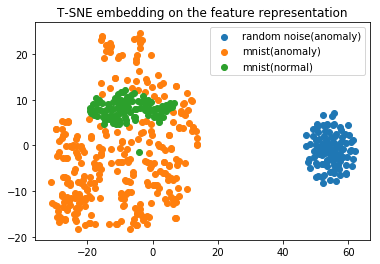

In [0]:
# Compressed in 2 dimensions so that feature space can be visualized
X_embedded = TSNE(n_components = 2).fit_transform(output)
plt.figure(5)
plt.title("T-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100, 0], X_embedded[:100, 1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400, 0], X_embedded[100:400, 1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:, 0], X_embedded[400:, 1], label='mnist(normal)')
plt.legend()
plt.show()

# Change anomaly score calculation

-Change noise generation to multiple
-Learn Generator

In [0]:
%%time
def anomaly_detector_second(g: Model, d: Model, in_shape: tuple=(10,), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    ノイズを生成する層と生成モデルを調整して異常スコアと画像を生成するモデルを作成
    
    Parameters
    ----------
    g: Model
        生成モデル
    d: Model
        識別モデル
    in_shape: tuple
        ノイズの入力サイズ
    loss_weights: list
        ロスの重要性を設定

    Returns
    -------
    model: Model
        異常スコアと画像を生成するモデル

    """
    # 特徴量抽出モデルをDiscriminatorから作成
    intermidiate_model = feature_extractor(d)
    # 特徴量抽出モデルは学習しない
    feature_extractor.trainable = False
    # Generatorを作成
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Generatorは学習
    g.trainable = True
    # Noizeを学習するためのレイヤー
    aInput = Input(shape=in_shape)
    gInput = Dense(in_shape[0], trainable=True)(aInput)
    gInput = Activation(AnomalyDetectorParam.activation_sigmoid.value)(gInput)
    
    # ノイズを入力に画像を生成
    G_out = g(gInput)
    # 画像から特徴量抽出
    D_out = intermidiate_model(G_out)
    # 画像と特徴量を出力とするモデルを作成
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorParam.optimizer_rmsprop.value)
    
    # BatchNormを固定して学習しないようにする
    K.set_learning_phase(0)
    
    return model

  
def compute_anomaly_score_second(model: Model, x: np.array, iterations: int=5, z_num: int=5, d: Model=None, g: Model=None, noize_shape: tuple=(1, 10)) -> Tuple[np.asarray, np.asarray,]:
    """
    異常スコアを計算する関数
    
    Parameters
    ----------
    model: Model
        異常スコアを計算するモデル
    x: np.array
        検証用画像
    iterations: int
        イテレーションを設定
    z_num: int
        ノイズを生成する回数を設定
    d: Model
        識別モデル
    g: Model
        生成モデル
    noize_shape: tuple
        ノイズの次元を設定

    Returns
    -------
    loss: np.asarray
        異常スコア
    similar_data: np.asarray
        ノイズを調整したモデルにノイズを入力して画像を生成
    """
    loss_list = []
    similar_data_list = []
    # Generatorを学習していない初期状態として保持
    initial_g = copy.deepcopy(g)
    
    # ノイズを複数発生させて平均をとる
    for i in range(z_num):
        z = np.random.uniform(0, 1, size=noize_shape)
        # 特徴量抽出モデルを作成
        intermidiate_model = feature_extractor(d)
        # 実画像の特徴量抽出
        d_x = intermidiate_model.predict(x)
        # ノイズを入力として、実画像、実画像の特徴量をターゲットとしたノイズの学習を行う
        loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
        # ノイズから画像を作成
        similar_data, _ = model.predict(z)
        # 異常スコアを導出
        loss = loss.history['loss'][-1]
        loss_list.append(loss)
        similar_data_list.append(similar_data)
        # Generatorを学習していないものに設定しなおす
        model = anomaly_detector_second(g=initial_g, d=d)
      
    average_loss = np.average(loss_list)
    average_similar_data = np.average(similar_data_list, axis=0)
    
    return average_loss, average_similar_data
  
  
def anomaly_detection_second(test_img, g=None, d=None, iterations: int=5) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
    異常スコアを計算する関数(Gneratorの調整、ノイズを複数回発生させる部分を調整)
    
    Parameters
    ----------
    test_img: np.asarray
        検証用の画像
    g: Model
        異常スコアを計算するモデル
    d: Model
        識別モデル
    iterations: int
        イテレーションを設定

    Returns
    -------
    ano_score: np.asarray
        異常スコア
    original_x: np.asarray
       0-255の画素領域に調整した検証用画像
    similiar_x: np.asarray
       異常スコアを計算するモデルから生成された画像
    show:
       検証用画像と生成された画像の差分
    """
    # 異常スコアを計算するモデル
    model = anomaly_detector_second(g=g, d=d)
    # 画像のシェイプを取得
    test_img_shape = test_img.shape
    # テスト画像から異常スコアと類似画像を推定
    ano_score, similar_img = compute_anomaly_score_second(model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), iterations=iterations, d=d, g=g)
    
    # 実画像と類似画像の差分を導出
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4
    
    # uint8化して255倍する。0-255の画素領域にする
    np_residual = (255 * np_residual).astype(np.uint8)
    # オリジナルが画像と類似画像も同様に0-255画素領域にする
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    
    # GRAYカラー画像に変換
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    
    return ano_score, original_x, similiar_x, show
  
  
g, d  = load_models()
start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_second(test_image, g=g, d=d, iterations=4,)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 262.81 43877.68ms
CPU times: user 9min 15s, sys: 8.2 s, total: 9min 23s
Wall time: 9min 23s


手法を変えて異常スコアと検証データと異常データとその差分を出力

anomaly score :  262.8119873046875


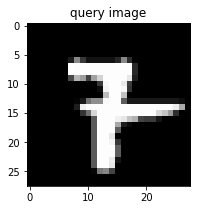

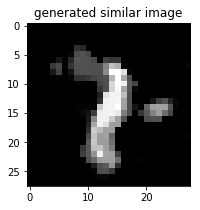

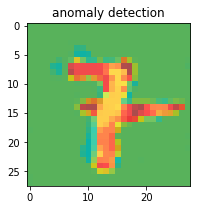

In [0]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

# EfficentGAN-BasedAnomalyDetection

- 高速な異常検知GANの実装

# Discriminator

- ノイズと画像を入力したDiscriminator

In [0]:
class DiscriminatorEncoderParam(Enum):
    conv2d_filter_64 = 64
    conv2d_kernel_4_4 = (4, 4)
    conv2d_stride_2_2 = (2, 2)
    conv2d_padding_same = 'same'
    
    leaky_relu_param_0_2 = 0.2
    drop_out_0_4 = 0.4
    
    noize_size_5_5_64 = 5 * 5 * 64
    
    leaky_relu_param_0_1 = 0.1
    
    dense_1024 = 1024
    
    out_dense_1 = 1
    out_activation_sigmoid = 'sigmoid'
    adam_lr_0_0002 = 0.0002
    beta_1_0_5 = 0.5
    loss_binary_crossentropy = "binary_crossentropy"
    metrics_accuracy = 'accuracy'

Model: "model_109"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1762 (Conv2D)            (None, 14, 14, 64)   1088        input_83[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_62 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_1762[0][0]                
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_62[0][0]             
__________________________________________________________________________________________

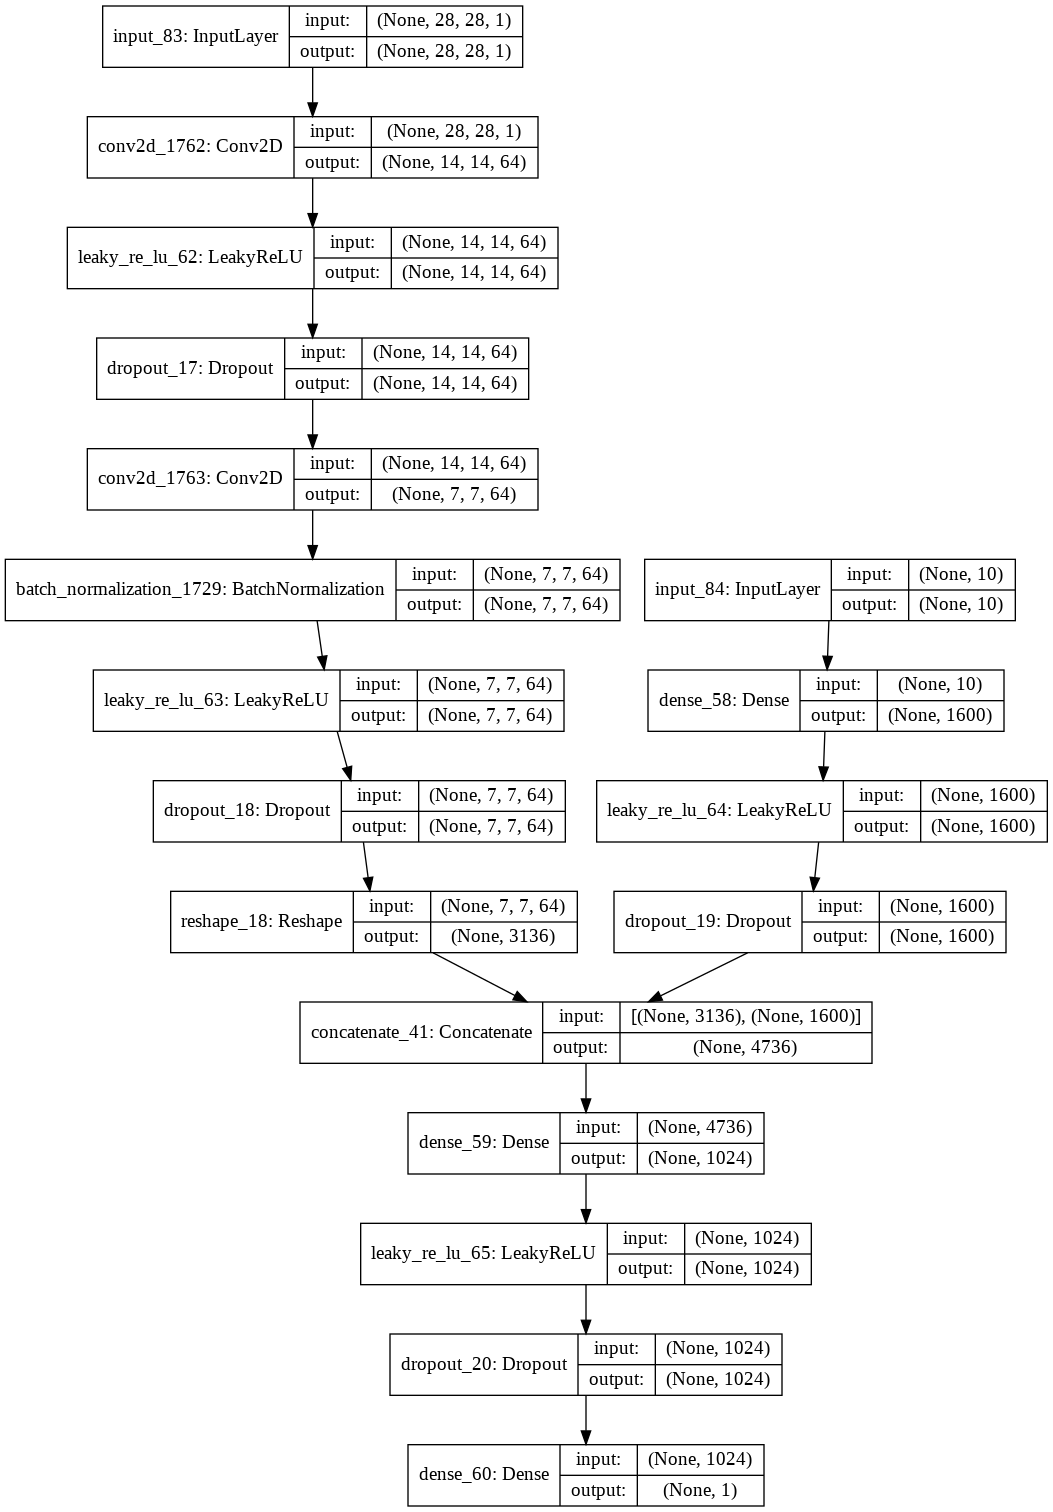

In [0]:
def define_discriminator(in_shape=(28,28,1), in_z=(10,)) -> Model:
    """
    識別モデルの作成
    
    Parameters
    ----------
    in_shape : tuple
        画像の次元
    in_z : tuple
        ノイズの次元
    
    Returns
    -------
    model: Model
        作成した識別モデル（ノイズと画像を入力にしている）
    """
    
    input_x = Input(shape=in_shape)
    x = Conv2D(DiscriminatorEncoderParam.conv2d_filter_64.value, 
               DiscriminatorEncoderParam.conv2d_kernel_4_4.value, 
               strides=DiscriminatorEncoderParam.conv2d_stride_2_2.value, 
               padding=DiscriminatorEncoderParam.conv2d_padding_same.value, 
               input_shape=in_shape)(input_x)

    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_2.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    x = Conv2D(DiscriminatorEncoderParam.conv2d_filter_64.value, 
               DiscriminatorEncoderParam.conv2d_kernel_4_4.value, 
               strides=DiscriminatorEncoderParam.conv2d_stride_2_2.value, 
               padding=DiscriminatorEncoderParam.conv2d_padding_same.value, 
               input_shape=in_shape)(x)

    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_2.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    # レイヤーのサイズを取得する
    shape_x = K.int_shape(x)
    # ノイズとconcatできるように1次元に変更、0次元はバッチサイズなので使用しない
    x = Reshape((shape_x[1] * shape_x[2] * shape_x[3],))(x)
    
    # ノイズの入力のレイヤー
    input_z = Input(shape=in_z)
    z = Dense(DiscriminatorEncoderParam.noize_size_5_5_64.value)(input_z)
    z = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_1.value)(z)
    z = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(z)
    
    # ノイズと画像抽出部分をconcate
    concat_x = concatenate([x, z], axis=1)
    x = Dense(DiscriminatorEncoderParam.dense_1024.value)(concat_x)
    x = LeakyReLU(alpha=DiscriminatorEncoderParam.leaky_relu_param_0_1.value)(x)
    x = Dropout(DiscriminatorEncoderParam.drop_out_0_4.value)(x)
    x = Dense(DiscriminatorEncoderParam.out_dense_1.value, activation=DiscriminatorEncoderParam.out_activation_sigmoid.value)(x)
    
    # ノイズと画像の情報使って識別する
    model = Model(inputs=[input_x, input_z], outputs=x)
    opt = Adam(lr=DiscriminatorEncoderParam.adam_lr_0_0002.value, beta_1=DiscriminatorEncoderParam.beta_1_0_5.value)
    model.compile(loss=DiscriminatorEncoderParam.loss_binary_crossentropy.value, optimizer=opt, metrics=[DiscriminatorEncoderParam.metrics_accuracy.value])
    return model
  
d_model = define_discriminator()
d_model.summary()
plot_model(d_model, to_file="d_plot.png", show_shapes=True, show_layer_names=True)

# Encoder

In [0]:
class EncoderParam(Enum):
    con2d_filter_32 = 32
    con2d_kernel_3_3 = (3, 3)
    con2d_strides_2_2 = (2, 2)
    conv2d_padding_same = 'same'
    
    con2d_filter_64 = 64
    
    leaky_relu_param_0_2 = 0.2
    
    adam_lr_0_0002 = 0.0002
    beta_1_0_5 = 0.5
    loss_binary_crossentropy = "binary_crossentropy"
    metrics_accuracy = 'accuracy'

Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1764 (Conv2D)         (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1765 (Conv2D)         (None, 7, 7, 32)          9248      
_________________________________________________________________
batch_normalization_1730 (Ba (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1766 (Conv2D)         (None, 4, 4, 64)          18496     
_________________________________________________________________
batch_normalization_1731 (Ba (None, 4, 4, 64)          25

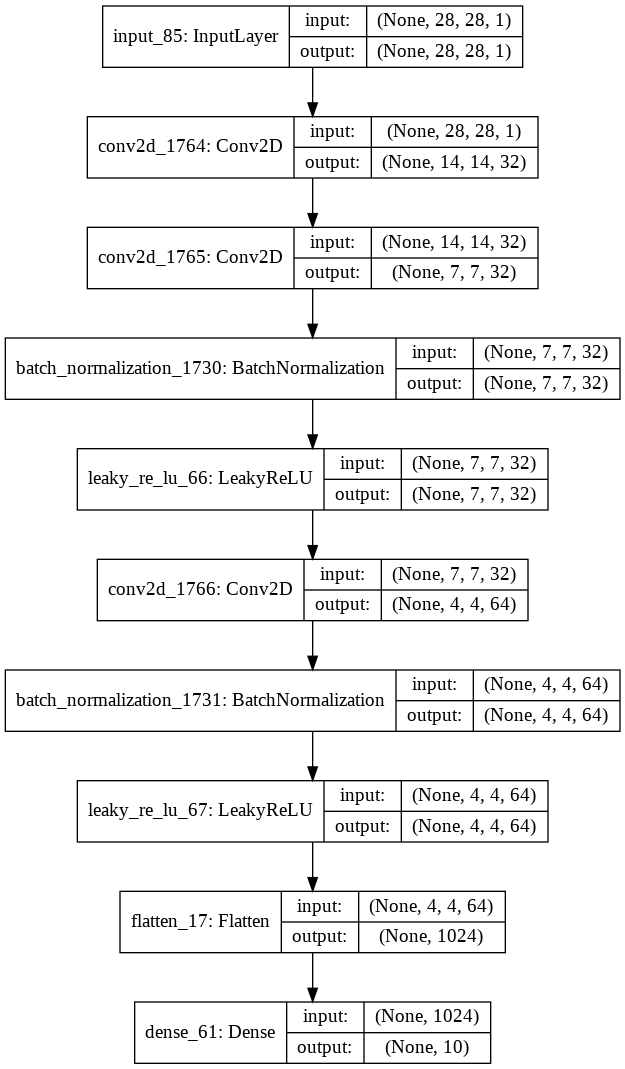

In [0]:
def define_encoder(in_shape: tuple=(28, 28, 1), out_z: tuple=(10,)) -> Model:
    """
    Encoderモデルの作成
    
    Parameters
    ----------
    in_shape : tuple
        画像の次元
    out_z : tuple
        出力ノイズの次元
    
    Returns
    -------
    model: Model
        作成したEncoderモデル
    """
    input_x = Input(shape=in_shape)
    x = Conv2D(EncoderParam.con2d_filter_32.value, 
               EncoderParam.con2d_kernel_3_3.value, 
               strides=EncoderParam.con2d_strides_2_2.value, 
               padding=EncoderParam.conv2d_padding_same.value)(input_x)
    x = Conv2D(EncoderParam.con2d_filter_32.value, 
               EncoderParam.con2d_kernel_3_3.value, 
               strides=EncoderParam.con2d_strides_2_2.value, 
               padding=EncoderParam.conv2d_padding_same.value)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=EncoderParam.leaky_relu_param_0_2.value)(x)
    x = Conv2D(EncoderParam.con2d_filter_64.value, 
               EncoderParam.con2d_kernel_3_3.value, 
               strides=EncoderParam.con2d_strides_2_2.value, 
               padding=EncoderParam.conv2d_padding_same.value)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=EncoderParam.leaky_relu_param_0_2.value)(x)
    x = Flatten()(x)
    x = Dense(out_z[0])(x)
    model = Model(inputs=input_x, outputs=x)
    opt = Adam(lr=DiscriminatorEncoderParam.adam_lr_0_0002.value, beta_1=DiscriminatorEncoderParam.beta_1_0_5.value)
    model.compile(loss=DiscriminatorEncoderParam.loss_binary_crossentropy.value, optimizer=opt, metrics=[DiscriminatorEncoderParam.metrics_accuracy.value])
    return model
  
encoder_model = define_encoder()
encoder_model.summary()
plot_model(encoder_model, to_file="encoder_model_plot.png", show_shapes=True, show_layer_names=True)

# ノイズを入力とするDiscriminatorの設定

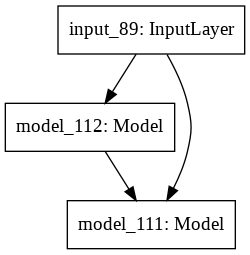

In [0]:
def generator_containint_discriminator(g_model: Model, d_model: Model, in_z: tuple=(10,)) -> Model:
    """
    Generatorを学習するためのDiscriminatorとの混合モデルの作成
    
    Parameters
    ----------
    g_model : Model
        生成モデル
    d_model : Model
        識別モデル
    in_z : tuple
        入力ノイズの次元
    
    Returns
    -------
    model: Model
        Generatorを学習するためのDiscriminatorとの混合モデル
    """
    d_model.trainable = False
    input_z = Input(shape=in_z)
    x = g_model(input_z)
    
    # 画像とノイズが入力
    x = d_model([x, input_z])
    
    gan = Model(inputs=input_z, outputs=x)
    return gan

d_model = define_discriminator()
g_model = generator_model()
g_d_model = generator_containint_discriminator(g_model, d_model)
plot_model(g_d_model, to_file='g_d_model.png')

# Encoderからノイズを発生してDiscriminatorで識別

Model: "model_116"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_115 (Model)               (None, 10)           38698       input_93[0][0]                   
__________________________________________________________________________________________________
model_114 (Model)               (None, 1)            4936257     input_93[0][0]                   
                                                                 model_115[1][0]                  
Total params: 4,974,955
Trainable params: 38,506
Non-trainable params: 4,936,449
__________________________________________________________________________________________________


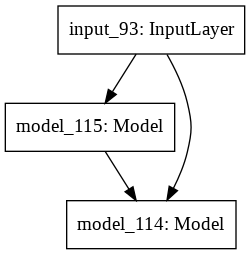

In [0]:
def define_encoder_gan(e_model, d_model, in_shape=(28,28,1)) -> Model:
    """
    Encoderを学習するためのDiscriminatorとの混合モデルの作成
    
    Parameters
    ----------
    e_model : Model
        Encoderモデル
    d_model : Model
        識別モデル
    in_shape : tuple
        画像の次元
    
    Returns
    -------
    model: Model
        Encoderを学習するためのDiscriminatorとの混合モデル
    """
    d_model.trainable = False
    input_x = Input(shape=in_shape)
    # Encoderで画像をノイズに
    x = e_model(input_x)
    
    x = d_model([input_x, x])
    
    model = Model(inputs=input_x, outputs=x)
    return model
  
d_model = define_discriminator()
e_model = define_encoder()
gan_encoder_model = define_encoder_gan(e_model, d_model)
gan_encoder_model.summary()
plot_model(gan_encoder_model, to_file='gan_encoder_model.png')

# Encoderを含むEfficientAnnoGANの学習

まれに初期値の関係でDiscriminatorが強くなりすぎる場合がある。その際は再学習が必要

Tensorboardを用いた学習ログの保存は時間がかかるので行わない

In [0]:
class TrainEncoderParam(Enum):
    discriminator_lr = 0.0002
    generator_lr = 0.0002
    encoder_lr = 0.0002
    
    generator_loss = "mse"
    discriminator_generator_loss = "mse"
    discriminator_encoder_loss = "mse"
    discriminator_loss = 'mse'

In [0]:
def train_encoder_gan(batch_size: int, X_train: np.ndarray, epoch: int=10, common_path: str='your model path') -> Tuple[Model, Model]:
    """
    識別モデルと生成モデルを学習する
    
    Parameters
    ----------
    batch_size: int
        バッチサイズ
    X_train: np.ndarray
        学習用画像データ
    epoch: int
        学習のエポック数を指定
    common_path : str
        モデル、生成画像を保存するパスを指定

    Returns
    -------
    d: Model
        識別モデル
    g: Model
        生成モデル

    """
    d = define_discriminator()
    g = generator_model()
    encoder = define_encoder()
    
    # Generatorのモデルを学習するための混合モデル
    d_on_g = generator_containint_discriminator(g, d)
    
    # Encoderのモデルを学習するための混合モデル
    d_on_e = define_encoder_gan(encoder, d)

    # 性能が良いとされるAdamに変更
    d_optim = Adam(lr=TrainEncoderParam.discriminator_lr.value)
    g_optim = Adam(lr=TrainEncoderParam.generator_lr.value)
    e_optim = Adam(lr=TrainEncoderParam.encoder_lr.value)
    
    g.compile(loss=TrainEncoderParam.generator_loss.value, optimizer=g_optim)
    d_on_g.compile(loss=TrainEncoderParam.discriminator_generator_loss.value, optimizer=g_optim)
    d_on_e.compile(loss=TrainEncoderParam.discriminator_encoder_loss.value, optimizer=e_optim)
    
    d.trainable= True
    d.compile(loss=TrainEncoderParam.discriminator_loss.value, optimizer=d_optim)
    
    for e in range(epoch):
        print('Eposh is ', e)
        # データサイズ / バッチサイズ = データサイズで何回バッチ処理が行えるか計算
        n_iter = int(X_train.shape[0] / batch_size)
        # 学習の進捗を分かりやすくするための処理
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # バッチサイズ分、10次元のノイズを取得、性能が良くなる正規分布に変更
            noise = np.random.normal(0, 1, size=(batch_size, 10))
            # 画像をバッチサイズ分取得
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            # ノイズから画像を生成
            generated_images = g.predict(noise, verbose=0)
            # 画像からノイズを生成
            generated_noise = encoder.predict(image_batch, verbose=0)
            
            # 生成画像を保存して後で確認できるようにする
            if index % 20 == 0:
                # バッチサイズ分画像ができるので1枚の画像に変換
                image = combine_images(generated_images)
                # -1 to 1スケールなので255スケールに変換
                image = image * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value
                if not os.path.exists(common_path + '/result/'):
                    os.makedirs(common_path + '/result/')
                cv2.imwrite(common_path + '/result/' + str(e) + '_' + str(index) + '.png', image)
           
            
            # Discriminatorの学習
            y = np.array([1] * batch_size)
            d_loss = d.train_on_batch([image_batch, generated_noise], y)
            
            y = np.array([0] * batch_size)
            d_loss = d.train_on_batch([generated_images, noise], y)
            
            # Discriminatorの学習はしない
            d.trainable = False

            # Generatorの学習
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * batch_size))
            d.trainable = False
            # Encoderの学習
            e_loss = d_on_e.train_on_batch(image_batch, np.array([0] * batch_size))
            
            d.trainable = True
            
            progress_bar.update(index, values=[('g', g_loss), ('d', d_loss), ('e', e_loss)])
        print('')
        # モデルを保存するディレクトリを作成
        if not os.path.exists(common_path + '/weights/'):
            os.makedirs(common_path + '/weights/')
        # モデルを保存
        g.save(common_path + '/weights/generator.h5')
        d.save(common_path + '/weights/discriminator.h5')
        encoder.save(common_path + '/weights/encoder.h5')
    return d, g, encoder

# 再現性を保つため乱数のseedを固定
np.random.seed(seed=30)
batch_size = 64
Model_d, Model_g, Model_e = train_encoder_gan(batch_size, X_train)

Eposh is  0
104/105 [============================>.] - ETA: 1s - g: 0.9456 - d: 0.0530 - e: 0.9844
Eposh is  1
104/105 [============================>.] - ETA: 0s - g: 0.9002 - d: 0.1003 - e: 0.9816
Eposh is  2
104/105 [============================>.] - ETA: 0s - g: 0.9535 - d: 0.0376 - e: 0.9605
Eposh is  3
104/105 [============================>.] - ETA: 0s - g: 0.7959 - d: 0.1723 - e: 0.8514
Eposh is  4
104/105 [============================>.] - ETA: 0s - g: 0.7682 - d: 0.1456 - e: 0.7643
Eposh is  5
104/105 [============================>.] - ETA: 0s - g: 0.7612 - d: 0.1576 - e: 0.6879
Eposh is  6
104/105 [============================>.] - ETA: 0s - g: 0.7610 - d: 0.1424 - e: 0.7418
Eposh is  7
104/105 [============================>.] - ETA: 0s - g: 0.6510 - d: 0.2184 - e: 0.5939
Eposh is  8
104/105 [============================>.] - ETA: 0s - g: 0.6875 - d: 0.1665 - e: 0.5817
Eposh is  9
104/105 [============================>.] - ETA: 0s - g: 0.5915 - d: 0.2134 - e: 0.5893


Encodeを含んだモデルのためそれ用に特徴量抽出関数、異常スコアモデル作成関数、異常スコア導出関数などを変更する

In [0]:
class FeatureExtractorEncodeParam(Enum):
    feature_extractor_loss = 'binary_crossentropy'
    optimizer = 'adam'
    
class AnomalyDetectorEncodeParam(Enum):
    adam = 'adam'

Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1776 (Conv2D)            (None, 14, 14, 64)   1088        input_94[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_79 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_1776[0][0]                
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_79[0][0]             
__________________________________________________________________________________________

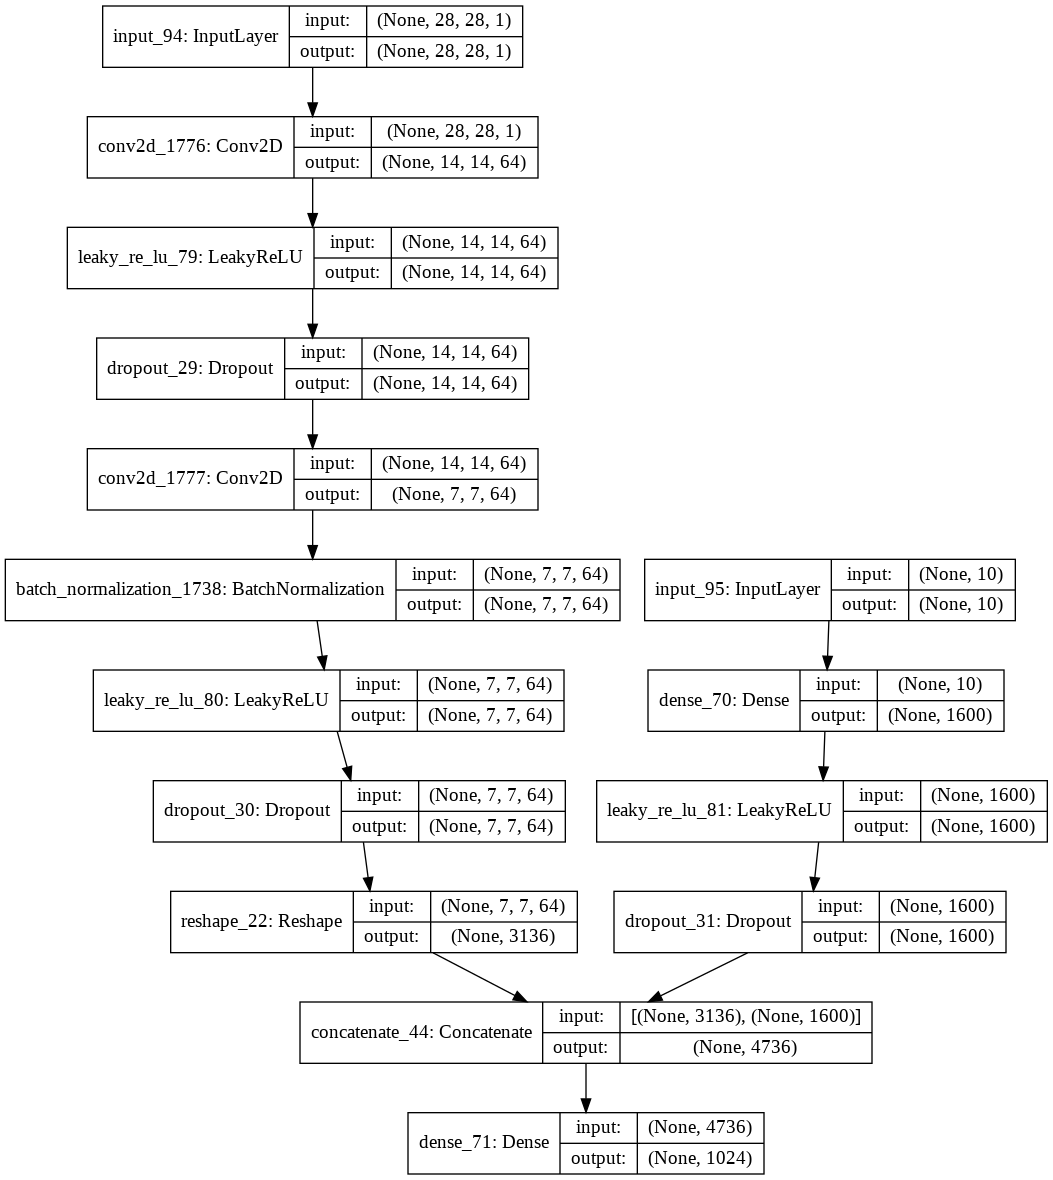

In [0]:
def feature_extractor_encode(d: Model=None, common_path: str=DataParm.common_path_efficient.value) -> Model:
    """
    識別モデルから特徴量抽出モデルを取得する
    
    Parameters
    ----------
    d: Model
        識別モデル
    common_path: str
        モデルを読み込むパスの設定

    Returns
    -------
    intermidiate_model: Model
        特徴量抽出モデル

    """
    if d is None:
        d = load_model(common_path + '/weights/discriminator.h5')
        d.summary()
    input_layer = []
    # 複数の入力特徴レイヤーがあるため特徴レイヤーを確保
    for index, each_d in enumerate(d.layers):
        if 'input' in each_d.name:
            input_layer.append(each_d.input)
    # Discriminatorの特徴量抽出器を設定
    intermidiate_model = Model(inputs=input_layer, outputs=d.layers[-4].output)
    intermidiate_model.compile(loss=FeatureExtractorEncodeParam.feature_extractor_loss.value, optimizer=FeatureExtractorEncodeParam.optimizer.value)
    return intermidiate_model

feature_extractor_model = feature_extractor_encode()
feature_extractor_model.summary()
plot_model(feature_extractor_model, to_file="feature_extractor_model_plot.png", show_shapes=True, show_layer_names=True)

# Encoderを含んだモデルによる異常スコア導出

In [0]:
def anomaly_detector_encode(g: Model, d: Model, e: Model, img_shape: tuple=(28, 28, 1), loss_weights: list=[0.9, 0.1]) -> Model:
    """
    異常スコアと画像を生成するモデルを作成
    
    Parameters
    ----------
    g: Model
        生成モデル
    d: Model
        識別モデル
    e: Model
        Encoderモデル
    img_shape: tuple
        画像の入力サイズ
    loss_weights: list
        ロスの重要性を設定

    Returns
    -------
    model: Model
        異常スコアと画像を生成するモデル

    """
    # 特徴量抽出モデルをDiscriminatorから作成
    intermidiate_model = feature_extractor_encode(d)
    # 特徴量抽出モデルは学習しない
    intermidiate_model.trainable = False
    # Generatorを作成
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    # Generatorは学習しない
    g.trainable = False
    # Encoderは学習しない
    e.trainable = False
    # Noizeを出力するためのレイヤー
    e = Model(inputs=e.layers[1].input, outputs=e.layers[-1].output)
    # 画像を入力
    aInput = Input(shape=img_shape)

    # ノイズを生成
    E_out = e(aInput)
    # ノイズを入力に画像を生成
    G_out = g(E_out)
    # 画像から特徴量抽出
    D_out = intermidiate_model([G_out, E_out])
    # 画像と特徴量を出力とするモデルを作成
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights=loss_weights, optimizer=AnomalyDetectorEncodeParam.adam.value)
    
    # BatchNormを固定して学習しないようにする
    K.set_learning_phase(0)
    
    return model

def compute_anomaly_score_encode(model: Model, intermidiate_model: Model, x: np.array, noise: np.array, d: Model=None, e: Model=None, g: Model=None) -> Tuple[np.asarray, np.asarray,]:
    """
    異常スコアを計算する関数
    
    Parameters
    ----------
    model: Model
        異常スコアを計算するモデル
    intermidiate_model: Model
        特徴量を抽出するモデル
    x: np.array
        検証用画像
    noise: np.array
        ノイズ
    d: Model
        識別モデル
    e: Model
        Encoderモデル
    g: Model
        生成モデル
    
    Returns
    -------
    loss: np.asarray
        異常スコア
    similar_data: np.asarray
        ノイズを調整したモデルにノイズを入力して画像を生成
    """
    # ノイズを生成する
    generate_noise = e.predict(x)

    # 画像を生成する
    generate_image = g.predict(generate_noise)

    # 実画像の特徴量抽出
    target_d_x = intermidiate_model.predict([x, generate_noise])

    # 生成画像の特徴量抽出
    d_x = intermidiate_model.predict([generate_image, noise])

    # 生成画像を入力として、実画像、実画像＋生成ノイズの特徴量の評価を行う
    # loss = model.evaluate(generate_image, [x, target_d_x], batch_size=1, verbose=0)
    # ノイズから画像を作成
    similar_data, _ = model.predict(generate_image)
    # 生成画像を入力として、実画像のロスを導出
    loss_image = [np.abs(each_x - g_x) for each_x, g_x in zip(x, generate_image)]
    sum_loss_image = np.sum(loss_image)
    # 特徴量を入力として、特徴量のロスを導出
    loss_feature = [np.abs(each_d_x - each_g_d_x) for each_d_x, each_g_d_x in zip(target_d_x, d_x)]
    sum_loss_feature = np.sum(loss_feature)

    # 異常スコアを導出
    loss = 0.9 * sum_loss_image + 0.1 * sum_loss_feature
    # loss = loss.history['loss'][-1]
    
    return loss, similar_data

def anomaly_detection_encode(test_img, noise, g=None, d=None, e=None, model=None, intermidiate_model=None) -> Tuple[np.asarray, np.asarray, np.asarray, np.asarray,]:
    """
    異常スコアを計算する関数(Gneratorの調整、ノイズを複数回発生させる部分を調整)
    
    Parameters
    ----------
    test_img: np.asarray
        検証用の画像
    g: Model
        生成モデル
    d: Model
        識別モデル
    e: Model
        Encoderモデル
    model: Model
        異常スコアを計算するモデル
    intermidiate_model: Model
        特徴量を抽出するモデル

    Returns
    -------
    ano_score: np.asarray
        異常スコア
    original_x: np.asarray
       0-255の画素領域に調整した検証用画像
    similiar_x: np.asarray
       異常スコアを計算するモデルから生成された画像
    show:
       検証用画像と生成された画像の差分
    """
        
    # 画像のシェイプを取得
    test_img_shape = test_img.shape

    # テスト画像から異常スコアと類似画像を推定
    ano_score, similar_img = compute_anomaly_score_encode(model, intermidiate_model, test_img.reshape(1, test_img_shape[0], test_img_shape[1], test_img_shape[2]), noise, d=d, e=e, g=g)

    # 実画像と類似画像の差分を導出
    np_residual = test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) - similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2])
    np_residual = (np_residual + 2) / 4
    
    # uint8化して255倍する。0-255の画素領域にする
    np_residual = (255 * np_residual).astype(np.uint8)
    # オリジナルが画像と類似画像も同様に0-255画素領域にする
    original_x = (test_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    similiar_x = (similar_img.reshape(test_img_shape[0], test_img_shape[1], test_img_shape[2]) * DataParm.image_size_127_5.value + DataParm.image_size_127_5.value).astype(np.uint8)
    
    # GRAYカラー画像に変換
    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    
    return ano_score, original_x, similiar_x, show

Generator, Discriminator, Encoderの学習済みモデルを取得

In [0]:
def load_models_encoder(common_path: str=DataParm.common_path_efficient.value) -> Tuple[Model, Model]:
    """
    学習した生成モデルと識別モデル、Encoderモデルを読み込む
    
    Parameters
    ----------
    common_path : str
        モデルを読み込むパスを指定

    Returns
    -------
    g: Model
        生成モデル
    d: Model
        識別モデル
    """
    d = load_model(common_path + '/weights/discriminator.h5')
    g = load_model(common_path + '/weights/generator.h5')
    e = load_model(common_path + '/weights/encoder.h5')
    return g, d, e

g, d, e  = load_models_encoder()

7のラベルのデータを取得して異常検知性能を測る

In [0]:
img_index = 14
label_index = 7
test_image = X_test_original[y_test==label_index][img_index]

異常スコアを計算、モデルから画像を生成する。GPUの性質上、1度めの予測は遅くなる

In [0]:
# 異常スコアを計算するモデル
model = anomaly_detector_encode(g=g, d=d, e=e)
# 特徴量抽出モデルを作成
intermidiate_model = feature_extractor_encode(d)

1度目はGPUの初期化などで遅いので、生成したモデルを再利用して高速に推論する。

In [0]:
%%time

noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 373.76 6525.34ms
CPU times: user 1min 4s, sys: 801 ms, total: 1min 5s
Wall time: 1min 5s


In [0]:
%%time

noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

7 label, 14 : done 363.91 6.85ms
CPU times: user 72.4 ms, sys: 2.11 ms, total: 74.5 ms
Wall time: 69.5 ms


入力画像と生成画像とその差分を表示する

anomaly score :  363.9063415527344


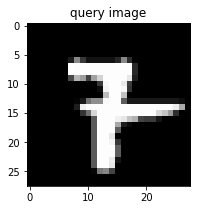

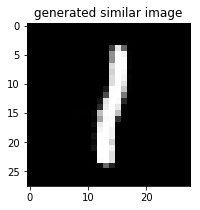

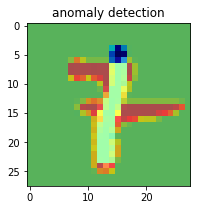

In [0]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28, 28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28, 28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

1のラベルのデータを取得して異常検知性能を測る

In [0]:
img_index = 14
label_index = 1
test_image = X_test_original[y_test==label_index][img_index]

異常スコアを計算、モデルから画像を生成する

In [0]:
noise = np.random.normal(0, 1, size=(1, 10))

start = cv2.getTickCount()
score, query, pred, diff = anomaly_detection_encode(test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 100
print ('%d label, %d : done'%(label_index, img_index), '%.2f' %score, '%.2fms' %time)

1 label, 14 : done 115.88 6.24ms


入力画像と生成画像とその差分を表示する

anomaly score :  115.88379135131837


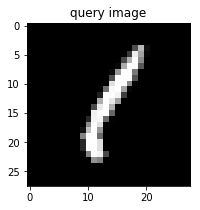

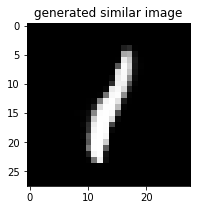

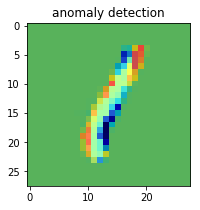

In [0]:
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(query.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

# ノイズ画像と1の画像とそれ以外の画像の特徴量空間を観測してみる

In [0]:
# 28x28x1の画像を100枚作成
random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
random_noise = np.random.uniform(0, 1, (100, 10))

model = feature_extractor_encode()
# ランダムな画像から特徴量抽出
feature_map_of_random = model.predict([random_image, random_noise], verbose=1)

Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1776 (Conv2D)            (None, 14, 14, 64)   1088        input_94[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_79 (LeakyReLU)      (None, 14, 14, 64)   0           conv2d_1776[0][0]                
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 14, 14, 64)   0           leaky_re_lu_79[0][0]             
__________________________________________________________________________________________

In [0]:
generate_noise_other = e.predict(X_test_original[y_test != 1][:300])
generate_noise = e.predict(X_test[:100])

100/100 [==============================] - 0s 555us/step
(500, 1024)


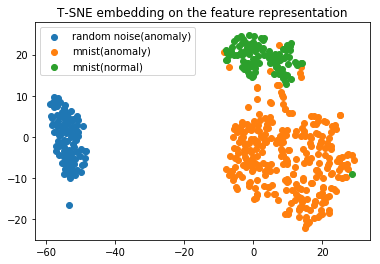

In [0]:
# ラベルが1でない画像の特徴量を抽出
feature_map_mnist = model.predict([X_test_original[y_test != 1][:300], generate_noise_other], verbose=1)
# ラベルが1の画像の特徴量を抽出
feature_map_mnist_1 = model.predict([X_test[:100], generate_noise], verbose=1)

# 先ほど出力した各特徴量空間を組み合わせる
output = np.concatenate((feature_map_of_random, feature_map_mnist, feature_map_mnist_1))
print(output.shape)
# 最初の次元だけ保って、他の次元は合成される
output = output.reshape(output.shape[0], -1)

# 特徴量空間を可視化できるように2次元に圧縮
X_embedded = TSNE(n_components = 2).fit_transform(output)
plt.figure(5)
plt.title("T-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100, 0], X_embedded[:100, 1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400, 0], X_embedded[100:400, 1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:, 0], X_embedded[400:, 1], label='mnist(normal)')
plt.legend()
plt.show()

# ROC-AUCの計算

学習に使用していないラベル1のデータとそれ以外のデータの異常スコアを用いてROC-AUCを計算する

In [0]:
g, d, e  = load_models_encoder()
# 異常スコアを計算するモデル
model = anomaly_detector_encode(g=g, d=d, e=e)
# 特徴量抽出モデルを作成
intermidiate_model = feature_extractor_encode(d)

ROC-AUCの計算にはTensorBoard使用時には10分程度、時間がかかる

In [0]:
%%time
from sklearn.metrics import roc_curve, auc

label_index = 1
test_image_set = X_test_original[y_test==label_index]
test_other_image_set = X_test_original[y_test!=label_index]

noise = np.random.normal(0, 1, size=(1, 10))
anomaly_score_list = []
y_true_list = []

# ラベル1の全データセットの異常スコアを計算してlist化
for each_test_image in test_image_set:
    score, query, pred, diff = anomaly_detection_encode(each_test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
    anomaly_score_list.append(score)
    y_true_list.append(0)

# ラベル1以外の全データセットの異常スコアを計算してlist化
for each_test_image in test_other_image_set:
    score, query, pred, diff = anomaly_detection_encode(each_test_image, noise, g=g, d=d, e=e, model=model, intermidiate_model=intermidiate_model)
    anomaly_score_list.append(score)
    y_true_list.append(1)
    
# False Positive Rate、True Positive Rateの導出
fpr, tpr, threshold = roc_curve(y_true_list, anomaly_score_list)
# AUCの値を計算
roc_auc = auc(fpr, tpr)

CPU times: user 10min 55s, sys: 20.3 s, total: 11min 16s
Wall time: 10min 31s


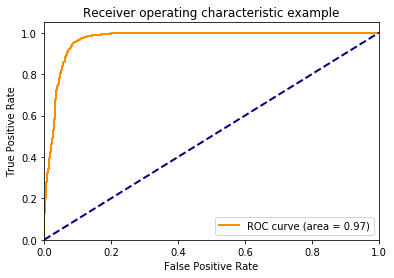

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()